In [1]:
#%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [2]:
class Planeta:

    def __init__(self, e, a, t,alpha=1.1e-8):

        self.t = t
        self.dt = t[1] - t[0] # Paso del tiempo

        self.e = e # Excentricidad
        self.a_ = a # Semi-eje mayor

        self.G = 4*np.pi**2 # Unidades gaussianas
        
        self.r = np.zeros(3)
        self.v = np.zeros_like(self.r)
        self.a = np.zeros_like(self.r)

        self.r[0] = self.a_*(1+self.e)
        self.v[1] = np.sqrt( self.G*(1-self.e)/(self.a_*(1.+self.e)) )

        self.R = np.zeros((len(t),len(self.r)))
        self.V = np.zeros_like(self.R)

        # El valor del pasado
        self.rp = self.r

    def GetAceleration(self,alpha=1.1e-8):

        d = np.linalg.norm(self.r)
        self.a = (-self.G/d**3)*(1+(alpha/d**2))*self.r


    def Evolution(self,i,alpha=1.1e-8):

        self.SetPosition(i)
        self.SetVelocity(i)
        self.GetAceleration()

        if i==0:
            self.r = self.rp + self.v*self.dt
        else:

            # rp pasado, r presente rf futuro
            self.rf = self.r + (self.v*self.dt) + (0.5 * self.a * self.dt**2)
            
            d = np.linalg.norm(self.rf)
            self.af = (-self.G/d**3)*(1+(alpha/d**2))*self.rf
        
            self.v = self.v +((self.dt/2)*(self.af+self.a))

            self.rp = self.r
            self.r = self.rf
            

    def SetPosition(self,i):
        self.R[i] = self.r

    def SetVelocity(self,i):
        self.V[i] = self.v

    def GetPosition(self,scale=1):
        return self.R[::scale]

    def GetVelocity(self,scale=1):
        return self.V[::scale]

    def GetPeriodo(self):

        Dist = np.linalg.norm(self.R,axis=1)

        timeup = []
        conteo =0
        periodo=[]


        for i in range(1,len(Dist)-1):
            conteo+=1
            if Dist[i] < Dist[i-1] and Dist[i] < Dist[i+1]:
                timeup.append(self.t[i])

                periodo.append(conteo)
                

        return periodo

In [3]:
def GetPlanetas(t):

    Mercurio = Planeta(0.205630,0.387098,t)
    

    return [Mercurio]

In [4]:
dt = 0.001
tmax = 2.4
t = np.arange(0.,tmax,dt)
Planetas = GetPlanetas(t)

In [5]:
def RunSimulation(t,Planetas):

    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):

        #print(it)
        for i in range(len(Planetas)):
            Planetas[i].Evolution(it)
            # Aca debes agregar la interaccion con la pared


    return Planetas

In [6]:
Planetas = RunSimulation(t,Planetas)


Running simulation: 100%|██████████| 2400/2400 [00:00<00:00, 43637.45 Steps/s]


In [7]:
scale = 20
t1 = t[::scale]


In [8]:
def Longitud_heliocentrica(mercurio):
    posiciones = mercurio.GetPeriodo()
 
    arcos = []
    tiempos = []
    for i in posiciones:
        
        distancia = mercurio.GetPosition()[i]
        
       
        angulo_rad = np.arctan2(abs(distancia[1]),abs (distancia[0]))
        angulo_deg = 2* np.degrees(angulo_rad)*3600
        
        arcos.append(angulo_deg)
        
       
        tiempo_siglos = float(2 * i *0.001)
        tiempos.append(tiempo_siglos)
    return [arcos, tiempos]

 
tiempo=Longitud_heliocentrica(Planetas[0])[0]
arcos=Longitud_heliocentrica(Planetas[0])[1]

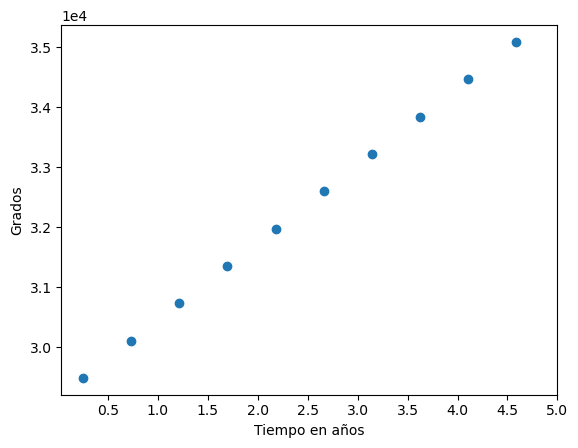

In [14]:

plt.scatter(arcos,tiempo)

plt.xticks([0.5,1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel("Tiempo en años")
plt.ylabel("Grados")

plt.show()

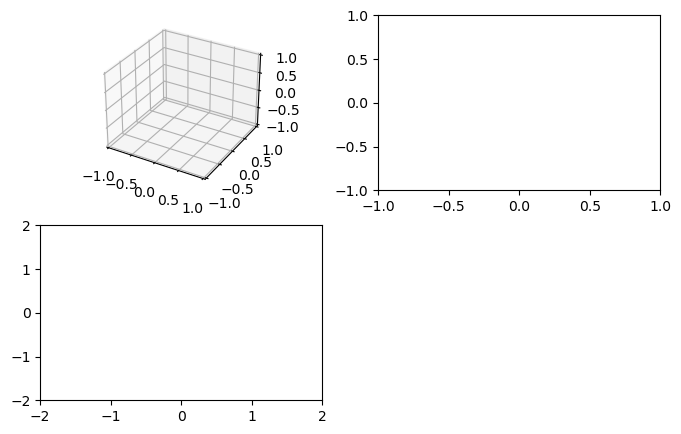

In [10]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(221,projection='3d')
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)

colors=['grey']

def init():

    ax.clear()
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)

    ax1.clear()
    ax1.set_xlim(-1,1)
    ax1.set_ylim(-1,1)

    ax2.clear()
    ax2.set_xlim(-2,2)
    ax2.set_ylim(-2,2)

def Update(i):

    init()

    for j, p in enumerate(Planetas):

        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        z = p.GetPosition(scale)[i,2]

        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        vz = p.GetVelocity(scale)[i,2]

        ax.scatter(0,0,0,s=200,color='y')
        ax.quiver(x,y,z,vx,vy,vz,color=colors[j],length=0.03)

        ax.scatter(x,y,z,color=colors[j])

        circle = plt.Circle((x,y),0.1,color=colors[j],fill=True)
        ax1.add_patch(circle)


Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)